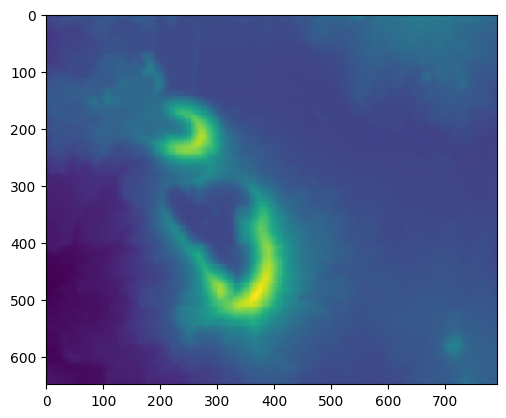

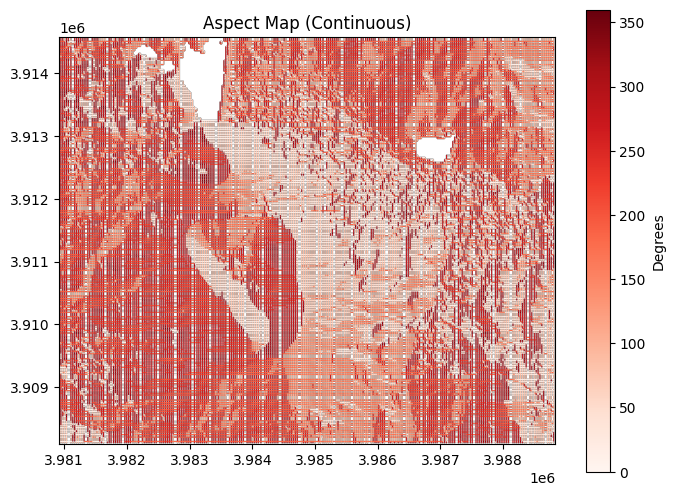

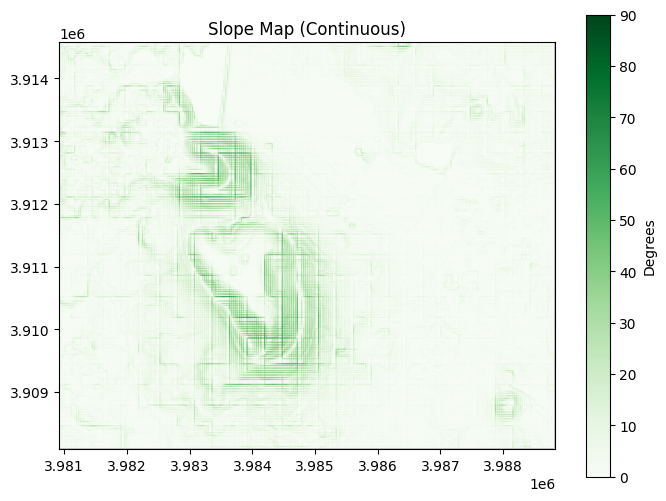

In [1]:

import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show

# 1) Load DEM
with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/dem_3857_700x500.tif") as src:
    dem_arr       = src.read(1)
    transform = src.transform
    crs       = src.crs
    bounds    = src.bounds
    height, width = dem_arr.shape

    plt.imshow(dem_arr)


with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/aspect_3857_700x500.tif") as src:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    show(src, ax=ax, cmap='Reds', vmin=0, vmax=360)
    ax.set_title('Aspect Map (Continuous)')
    plt.colorbar(ax.images[0], ax=ax, label='Degrees')
    plt.show()

with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/slope_3857_700x500.tif") as src:
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    show(src, ax=ax, cmap='Greens', vmin=0, vmax=90)
    ax.set_title('Slope Map (Continuous)')
    plt.colorbar(ax.images[0], ax=ax, label='Degrees')
    plt.show()


In [6]:
import rasterio
import numpy as np
import geopandas as gpd
from shapely.geometry import box
from rasterio.features import rasterize
from rasterio.warp import calculate_default_transform, reproject, Resampling

# 1) Load DEM
with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/dem_3857_700x500.tif") as src:
    dem_arr        = src.read(1)
    dem_meta       = src.meta
    transform  = src.transform
    crs        = src.crs
    bounds     = src.bounds
    height, width = dem_arr.shape


# 2-1) Load Aspect
# with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/aspect_3857_700x500.tif") as src:
#     aspect_arr = src.read(1)           # shape: (height, width)
#     aspect_meta = src.meta             # CRS, transform, dtype 등 메타정보 저장

# 2-2) (선택) 마스크된 nodata를 NaN으로 처리하려면:
with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/aspect_3857_700x500.tif") as src:
    aspect_ma = src.read(1, masked=True)   # masked array
    aspect_arr = aspect_ma.filled(np.nan)  # nodata → np.nan

# 3) Load Slope
with rasterio.open("/Users/hyangsuk/Documents/2025-1/2025-1-wargame/project/map/slope_3857_700x500.tif") as src:
    slope_arr = src.read(1)            # shape: (height, width)
    slope_meta = src.meta

# 4) 배열 확인
print("Dem array shape:", dem_arr.shape)
print("Aspect array shape:", aspect_arr.shape)
print("Slope array shape: ", slope_arr.shape)

Dem array shape: (649, 791)
Aspect array shape: (649, 791)
Slope array shape:  (649, 791)


In [3]:
# 5) Read & clip vector layers
clip_box = box(bounds.left, bounds.bottom, bounds.right, bounds.top)

road   = gpd.read_file("road/road.shp").to_crs(crs)
lake   = gpd.read_file("natural_water/natural_water.shp").to_crs(crs)
stream  = gpd.read_file("natural_stream/natural_stream.shp").to_crs(crs)
wood = gpd.read_file("natural_wood/natural_wood.shp").to_crs(crs)

road_clip   = gpd.clip(road,   clip_box)
lake_clip   = gpd.clip(lake,   clip_box)
stream_clip  = gpd.clip(stream,  clip_box)
wood_clip = gpd.clip(wood, clip_box)

# 4) Rasterize masks (1=feature, 0=background)
road_mask = rasterize(
    [(geom, 1) for geom in road_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)
lake_mask = rasterize(
    [(geom, 1) for geom in lake_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)
stream_mask = rasterize(
    [(geom, 1) for geom in stream_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)
wood_mask = rasterize(
    [(geom, 1) for geom in wood_clip.geometry],
    out_shape=(height, width),
    transform=transform,
    fill=0, dtype="uint8"
)


/var/folders/yn/87ddxk5x7ss89pw9xv4_4mfc0000gn/T/ipykernel_89912/500066962.py:21: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='lower right', fontsize='small')


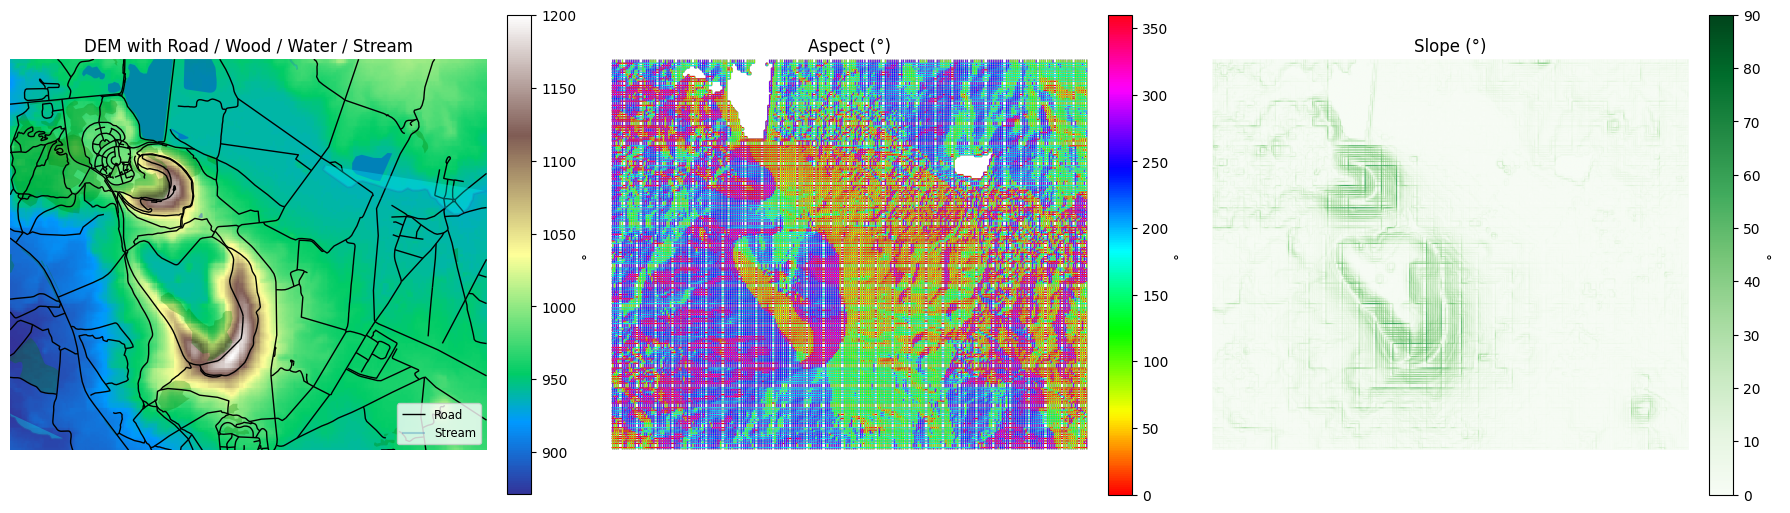

In [9]:
import matplotlib.pyplot as plt
from rasterio.plot import show

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1) DEM + vector overlays
ax = axes[0]

im0 = ax.imshow(
    dem_arr,
    cmap='terrain',
    extent=(bounds.left, bounds.right, bounds.bottom, bounds.top),
    origin='upper'
)

road_clip.plot(ax=ax, edgecolor='black', linewidth=1, facecolor='none', label='Road')
wood_clip.plot(ax=ax, facecolor='green', alpha=0.3, label='Wood')
lake_clip.plot(ax=ax, facecolor='blue', alpha=0.3, label='Water')
stream_clip.plot(ax=ax, facecolor='cyan', alpha=0.3, label='Stream')
ax.set_title('DEM with Road / Wood / Water / Stream')
ax.legend(loc='lower right', fontsize='small')
ax.axis('off')
fig.colorbar(im0, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='°')

# 2) Aspect (continuous 0–360°)
ax = axes[1]
im1 = ax.imshow(aspect_arr, cmap='hsv', vmin=0, vmax=360)
ax.set_title('Aspect (°)')
ax.axis('off')
fig.colorbar(im1, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='°')

# 3) Slope (continuous 0–90°)
ax = axes[2]
im2 = ax.imshow(slope_arr, cmap='Greens', vmin=0, vmax=90)
ax.set_title('Slope (°)')
ax.axis('off')
fig.colorbar(im2, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='°')

plt.tight_layout()
plt.show()


In [10]:
import numpy as np
from affine import Affine

# 1) transform, crs → 저장용 NumPy 배열/객체로 변환
# transform: Affine 객체 → GDAL 튜플 → float 배열
transform_arr = np.array(transform.to_gdal(), dtype=float)  # shape (6,)
# crs: rasterio CRS → 문자열 배열로 저장
crs_arr       = np.array(crs.to_string())

# 2) 모든 레이어 스택하지 않고 개별 키로 저장
np.savez_compressed(
    "golan_full_dataset_cropped.npz",
    # raster layers
    dem        = dem_arr,
    aspect     = aspect_arr,
    slope      = slope_arr,
    # vector masks
    road_mask   = road_mask.astype(np.uint8),
    lake_mask   = lake_mask.astype(np.uint8),
    stream_mask = stream_mask.astype(np.uint8),
    wood_mask   = wood_mask.astype(np.uint8),
    # # classification layers
    # ruggedness    = ruggedness.astype(np.uint8),
    # aspect_cat    = aspect_cat.astype(np.uint8),
    # wall_mask     = wall_mask.astype(np.uint8),
    # assembly_mask = assembly_mask.astype(np.uint8),
    # advance_mask  = advance_mask.astype(np.uint8),
    # metadata
    transform = transform_arr,
    crs       = crs_arr
)

print("→ golan_full_dataset_cropped.npz saved")


→ golan_full_dataset_cropped.npz saved


In [11]:
import numpy as np
from affine import Affine
from rasterio.crs import CRS

data = np.load("golan_full_dataset_cropped.npz", allow_pickle=True)

# 1) 래스터/마스크 레이어
dem_arr       = data["dem"]
aspect_arr    = data["aspect"]
slope_arr     = data["slope"]
road_mask     = data["road_mask"]
lake_mask     = data["lake_mask"]
stream_mask   = data["stream_mask"]
wood_mask     = data["wood_mask"]

# # 2) 분류 레이어
# ruggedness    = data["ruggedness"]
# aspect_cat    = data["aspect_cat"]
# wall_mask     = data["wall_mask"]
# assembly_mask = data["assembly_mask"]
# advance_mask  = data["advance_mask"]

# 3) 메타정보 복원
transform_arr = data["transform"]            # (6,) 배열
transform     = Affine.from_gdal(*transform_arr)
crs_str       = str(data["crs"].item())      # e.g. "EPSG:3857"
crs           = CRS.from_string(crs_str)
